<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg">

<CENTER>
</br>
<p><font size="5"> Big Data & Cloud Computing</span></p>
<p><font size="4">  Project 6 </font></p>
<p></p>
<p><font size="5">  Ocean warming contribution to Sea level rise </font></p>
</p></br>
</p>
</CENTER>

<p><font size="3"> Houda GHALLAB - Yassine SAOUD - Aymane HOUNA - Pierrot LEVASSEUR  </font></p>

----------------------------

### Imports and dataset

We first start by installing necessary requirements.

In [1]:
!pip install intake
!pip install intake-xarray
!pip install basemap
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.5 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=c8bb4144783db1fc9a4f0cd2d9ea0c2edc56a5035f204f4a1bd80e2f6b60806b
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 15.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.5 MB/s eta 0:00:00


In [2]:
import xarray as xr
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import numpy as np
import pandas as pd
from scipy.stats.mstats import zscore
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


In [3]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name, vmin=None, vmax=None, colormap='jet'):
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot

    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap=colormap,lw=0, vmin=vmin, vmax=vmax)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time-719177.25,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [5]:
#dataset
from intake import open_catalog
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2024/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)


In [6]:
temp_ds = cat["en4"].to_dask()
ssh_ds = cat["sea_surface_height"].to_dask()

In [7]:
temp = temp_ds['temperature']
sla = ssh_ds['sla']
temp = temp_ds.temperature - 273.15  # Since unit is K

We calculate the elementary area of the ocean

In [ ]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dS = R**2 * dϕ * dλ * np.cos(np.deg2rad(temp_ds.lat))

The last coordinate to calculate is the volume which is evaluated by taking the derivative of the depth of the ocean

In [ ]:
depths = temp['depth']
dz = depths.diff(dim='depth')
dz = xr.concat([xr.DataArray([5.022], dims='depth', coords={'depth': [5.022]}), dz], dim='depth')

In [ ]:
dV = dS * dz

We start by testing our algorithm on a specific month

In [ ]:
temp_ = temp.sel(time='2005-11', method='nearest')
temp__weighted_mean = (temp_ * dV).sum(dim=('lat', 'lon', 'depth')) / (dV.sum(dim=('lat', 'depth')) * 360)

In [ ]:
temp__weighted_mean.compute()

<xarray.DataArray ()>
array(1.78096507)
Coordinates:
    time     datetime64[ns] 2005-11-16

The value seems quite coherent so we move to evaluating the time series for the weighted temparture by applying the algorithm over the whole period

In [ ]:
temp_time_series = (temp * dV).sum(dim=('lat', 'lon', 'depth')) / (dV.sum(dim=('lat', 'depth')) * 360)
temp_time_series.compute()

<xarray.DataArray (time: 832)>
array([1.77360382, 1.77446696, 1.7739671 , 1.77543531, 1.7752339 ,
       1.77139059, 1.76902687, 1.76887308, 1.77111522, 1.77226926,
       1.77106016, 1.77319173, 1.77575081, 1.77635825, 1.77765603,
       1.77640413, 1.77368449, 1.77294562, 1.77070249, 1.77025056,
       1.77247512, 1.77352775, 1.77487882, 1.77661465, 1.77643367,
       1.77554768, 1.77467492, 1.77248791, 1.76853402, 1.76609816,
       1.76564535, 1.76681543, 1.76851609, 1.77034714, 1.76977952,
       1.77169059, 1.77432651, 1.77307948, 1.77439632, 1.77298497,
       1.77199473, 1.76956152, 1.76693751, 1.76718223, 1.76932702,
       1.77114264, 1.77158381, 1.77342792, 1.77488095, 1.77635582,
       1.77525125, 1.77530104, 1.77539363, 1.7710697 , 1.76972445,
       1.76937554, 1.77107007, 1.77286853, 1.77285233, 1.77281737,
       1.77289033, 1.77343452, 1.77458064, 1.77333642, 1.77358988,
       1.76870946, 1.76756504, 1.76749286, 1.76695411, 1.76886964,
       1.76598636, 1.76647163, 1.76935829, 1.7714998 , 1.7704012 ,
       1.76957748, 1.76737051, 1.76555036, 1.7649927 , 1.76642097,
       1.76782822, 1.76982028, 1.77226072, 1.77327999, 1.77374014,
       1.77281747, 1.77300254, 1.77003079, 1.76767559, 1.76517575,
       1.76182623, 1.76118505, 1.76354387, 1.76510092, 1.76674917,
       1.76897003, 1.76975252, 1.77061121, 1.7709285 , 1.77262797,
...
       1.78811222, 1.78724257, 1.7841408 , 1.78386095, 1.78365753,
       1.78422314, 1.78576961, 1.78396556, 1.78669999, 1.7877666 ,
       1.78810955, 1.78893638, 1.78857864, 1.78794696, 1.78570208,
       1.7835267 , 1.78210561, 1.78360547, 1.78501143, 1.78590849,
       1.78710203, 1.79126207, 1.79173861, 1.79195896, 1.79113521,
       1.78859123, 1.78662671, 1.78507405, 1.78367974, 1.78641124,
       1.78679783, 1.7879009 , 1.78977517, 1.78912464, 1.79055999,
       1.78967338, 1.78999662, 1.78952101, 1.79021607, 1.7880872 ,
       1.78733218, 1.78706161, 1.78826545, 1.78862687, 1.79137123,
       1.79215414, 1.79402722, 1.79439276, 1.79507484, 1.79345876,
       1.79054455, 1.78931986, 1.78916056, 1.78841433, 1.78926109,
       1.78982752, 1.79158366, 1.79144311, 1.79310974, 1.79348498,
       1.79283826, 1.79217007, 1.79107143, 1.78875157, 1.78678345,
       1.78907337, 1.78908428, 1.79072868, 1.79067165, 1.79321485,
       1.79258617, 1.79412796, 1.79579712, 1.79489852, 1.79309672,
       1.79214616, 1.79074857, 1.79010321, 1.79337642, 1.79286985,
       1.79291733, 1.79398924, 1.79537492, 1.79654969, 1.79639986,
       1.79440241, 1.79344632, 1.79194887, 1.79143075, 1.79166155,
       1.79346916, 1.79390982, 1.79465225, 1.7943467 , 1.79333506,
       1.79221442, 1.79033093])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

To plot the time series we have to fetch the coordinates from the dataset

In [ ]:
time = temp['time']
lon = temp['lon']
lat = temp['lat']

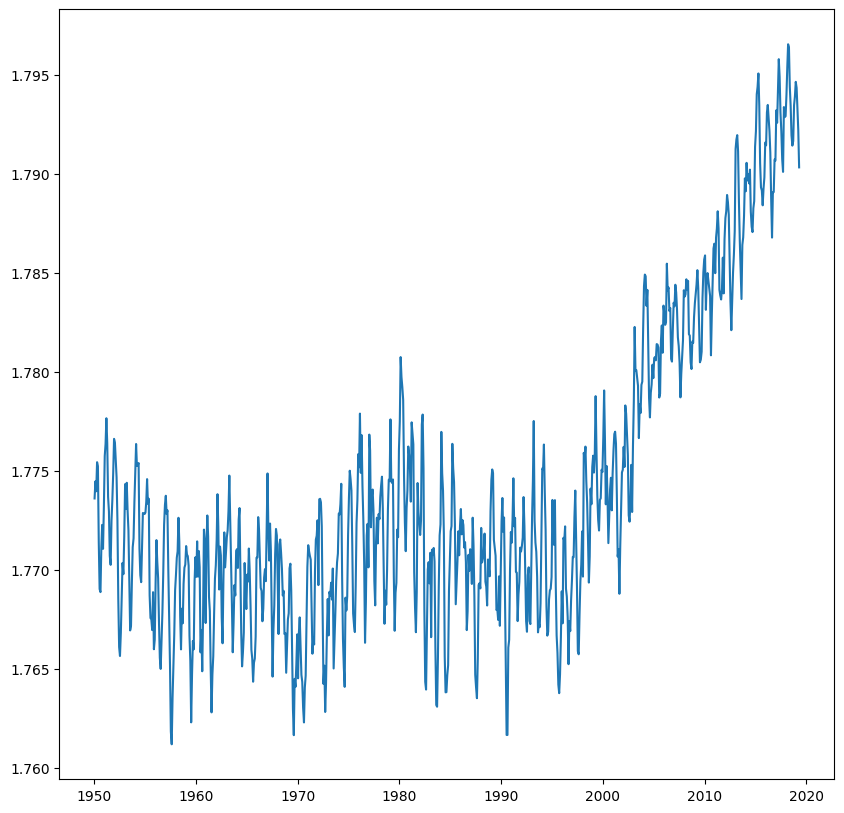

In [ ]:
figure(figsize=((10, 10)))
plot(time, temp_time_series)

To observe the general tendency of temperature's variation we can smooth the curve via a running average, the window being 24 which corresponds to 2 years

In [ ]:
# Define the window size for the running average
window_size = 24

# Calculate the running average using the rolling method and mean function
running_avg_temp = temp_time_series.rolling(time=window_size, center=True).mean()

running_avg_temp.compute()

<xarray.DataArray (time: 832)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 1.77337011, 1.77348802, 1.77353305,
       1.77356255, 1.77343974, 1.77316058, 1.77294006, 1.77279916,
       1.77271343, 1.77260513, 1.77252504, 1.77247168, 1.77240913,
       1.77234979, 1.77221317, 1.77207735, 1.77193489, 1.77186448,
       1.77172348, 1.7715666 , 1.77143875, 1.77130758, 1.7712082 ,
       1.77107091, 1.77093813, 1.77087344, 1.77090711, 1.77093112,
       1.77104834, 1.77133415, 1.7715413 , 1.77171126, 1.77181793,
       1.77192435, 1.77202941, 1.77215744, 1.77220439, 1.77214455,
       1.77215934, 1.77216702, 1.77218167, 1.77224813, 1.77221263,
       1.77223878, 1.77225172, 1.77215285, 1.77205814, 1.77182491,
       1.77153507, 1.77130496, 1.77110262, 1.77090054, 1.77066205,
       1.77032776, 1.77009778, 1.76990063, 1.76977752, 1.76964244,
       1.76951543, 1.76949078, 1.76951006, 1.76954547, 1.76951976,
       1.769454  , 1.76931627, 1.76906984, 1.7689226 , 1.76868348,
       1.76842066, 1.76827857, 1.76812154, 1.76815332, 1.76825742,
       1.76827385, 1.76823682, 1.76825879, 1.7683859 , 1.76855417,
       1.76864312, 1.76868424, 1.76875158, 1.76872949, 1.76870749,
       1.76861768, 1.76849192, 1.768386  , 1.76830074, 1.76820436,
...
       1.78542197, 1.78557153, 1.78571151, 1.78577492, 1.78576202,
       1.78581492, 1.78584447, 1.78586196, 1.78584824, 1.7858744 ,
       1.78613592, 1.78634231, 1.78653883, 1.78666479, 1.78672098,
       1.78682456, 1.78687511, 1.78687603, 1.78696721, 1.78701005,
       1.78717402, 1.78730215, 1.78735874, 1.78746084, 1.78749155,
       1.78755063, 1.78761622, 1.7878043 , 1.78799432, 1.78821209,
       1.7883561 , 1.78849168, 1.78860495, 1.78878283, 1.78882   ,
       1.78891536, 1.78901677, 1.78918092, 1.78938373, 1.78954698,
       1.78972389, 1.78995225, 1.79003572, 1.79013835, 1.79021863,
       1.79029398, 1.79039058, 1.79049682, 1.79065564, 1.79077404,
       1.79088442, 1.79092006, 1.79094774, 1.79092488, 1.7910087 ,
       1.79104282, 1.79113039, 1.79110124, 1.79114544, 1.7910854 ,
       1.79107436, 1.79110446, 1.79116445, 1.79127079, 1.79138855,
       1.79145472, 1.79152509, 1.79169656, 1.79182333, 1.7918789 ,
       1.79198498, 1.79207937, 1.79220706, 1.79235546, 1.79244848,
       1.79254743, 1.79268065, 1.79287429, 1.79298213, 1.79316483,
       1.79329738, 1.79346324, 1.7935104 , 1.7935416 , 1.79346187,
       1.79323411,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

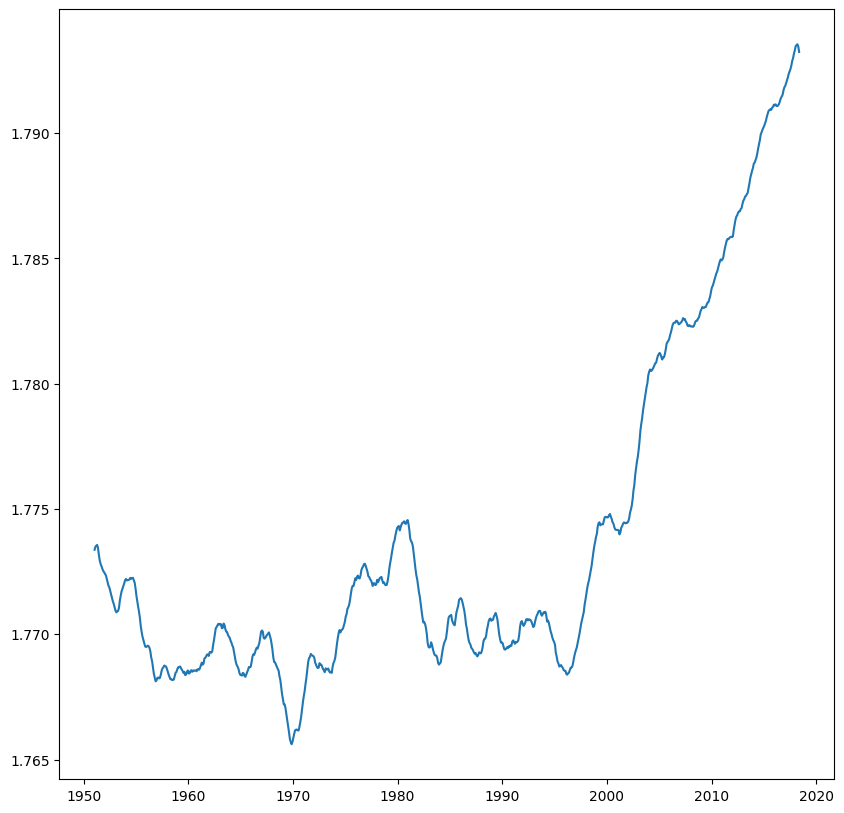

In [ ]:
figure(figsize=(10, 10))
plot(time, running_avg_temp)

Next, we want to observe the tendendy of temperature's variation

In [ ]:
temp_time_series_diff = temp_time_series.diff(dim='time')
# temp_map_diff = xr.concat([xr.DataArray([0], dims='time', coords={'time': [5.022]}), temp_map_diff], dim='time')
time_diff = time.diff(dim='time')

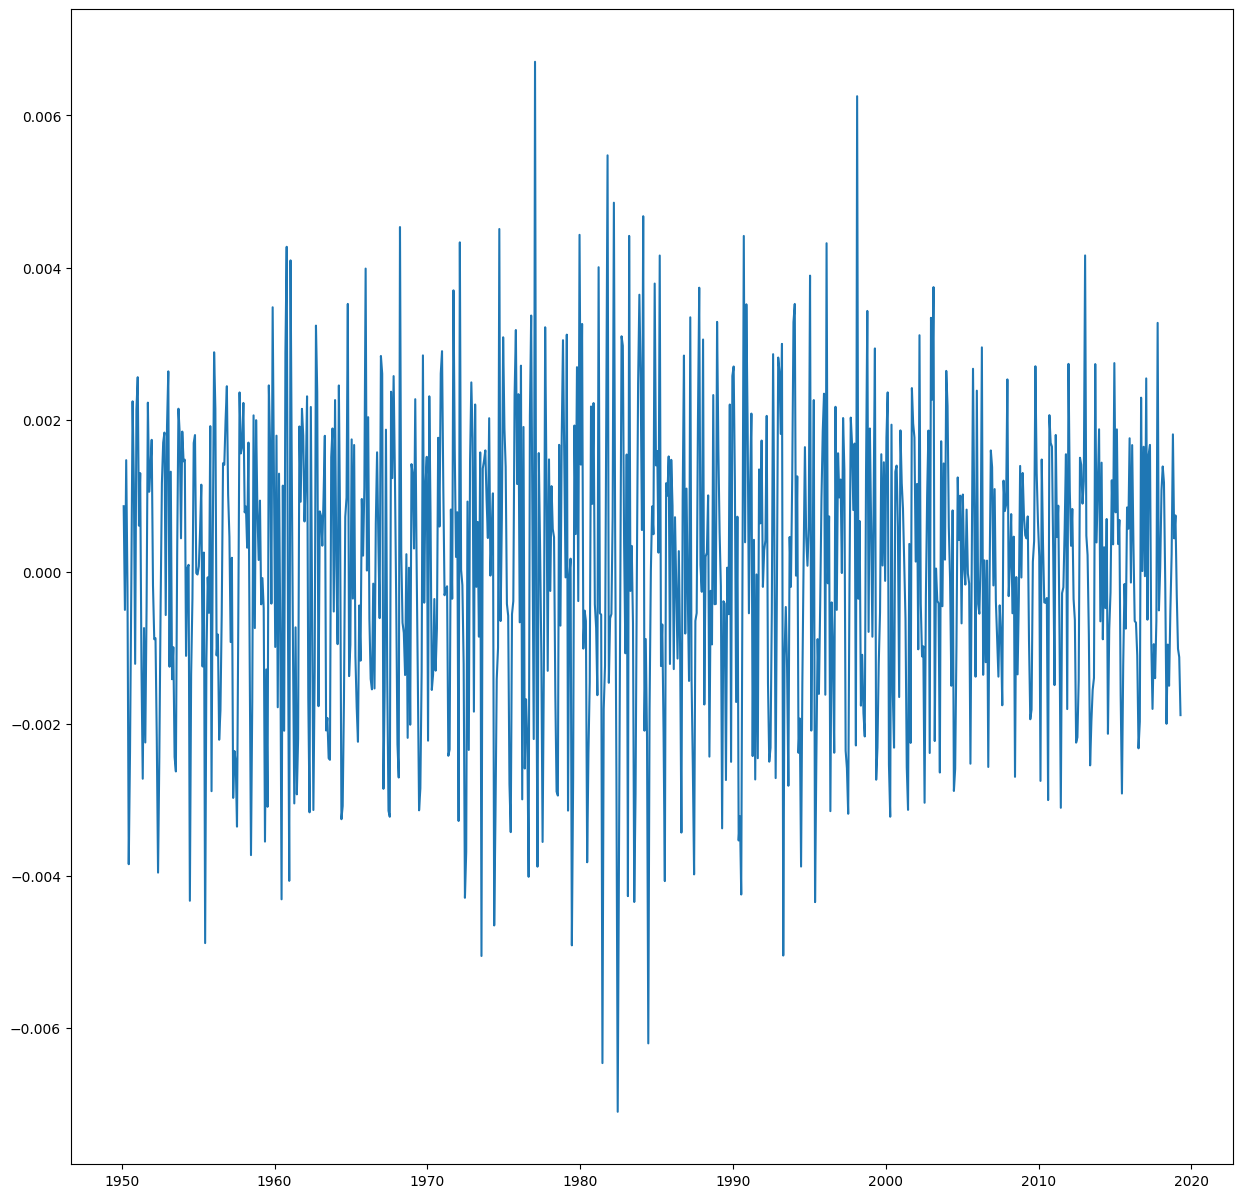

In [ ]:
plot(time[1:], temp_time_series_diff)

Now we want to observe the average temparature in each region. We start by viewing a map of the temparature in a random month

In [ ]:
temp_map = (temp * dz).sum(dim=('depth')) / (dz.sum(dim=('depth')))
temp_map.compute()

<xarray.DataArray (time: 832, lat: 173, lon: 360)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.36118878, -0.36092165, -0.36037852, ..., -0.36465998,
         -0.36408417, -0.36186116],
        [-0.37463268, -0.37459901, -0.3744044 , ..., -0.41590889,
         -0.41557713, -0.37483828],
        [-0.37527902, -0.37511773, -0.37486576, ..., -0.41670618,
         -0.41645917, -0.3754777 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [-0.30781738, -0.30734276, -0.30708045, ..., -0.31214478,
         -0.31124206, -0.30862419],
        [-0.32791943, -0.32708327, -0.32665069, ..., -0.37010346,
         -0.36949772, -0.32834994],
        [-0.33706665, -0.33660323, -0.33629164, ..., -0.37890348,
         -0.37854732, -0.33733638]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.31729037, -0.31742971, -0.31753394, ..., -0.32146087,
         -0.32065228, -0.31811428],
        [-0.3353592 , -0.33455982, -0.33411285, ..., -0.37746059,
         -0.37684215, -0.33579171],
        [-0.34358409, -0.34312515, -0.34279309, ..., -0.38538706,
         -0.38501458, -0.3438657 ]]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

In [ ]:
temp_map_one_month = temp_map.sel(time='2005-11', method='nearest')

aa


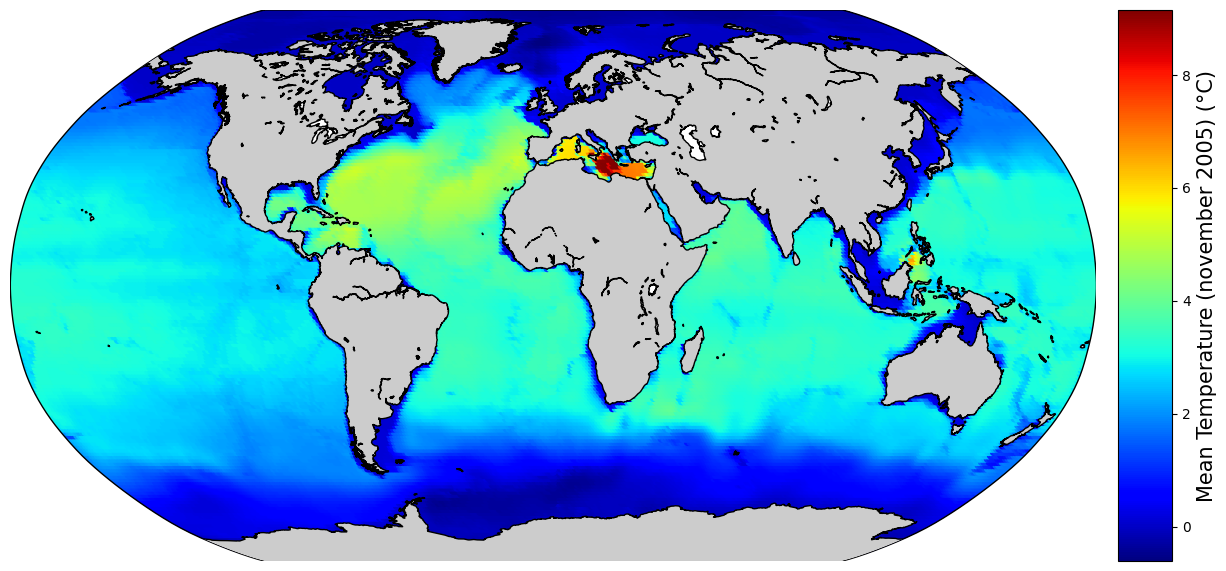

In [ ]:
LON, LAT = meshgrid(lon, lat)
plot_im(ravel(LON), ravel(LAT), ravel(temp_map_one_month), 30, 'Mean Temperature (november 2005) (°C)')

In [ ]:
mean_temp_map = temp_map.mean(dim='time')
mean_temp_map.compute()

<xarray.DataArray (lat: 173, lon: 360)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.37520861, -0.37483421, -0.37431787, ..., -0.37831075,
        -0.37788575, -0.37578895],
       [-0.38742298, -0.38734399, -0.38718616, ..., -0.42887117,
        -0.42853853, -0.38761251],
       [-0.38635704, -0.38620494, -0.38601735, ..., -0.42794413,
        -0.42770628, -0.38652342]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

aa


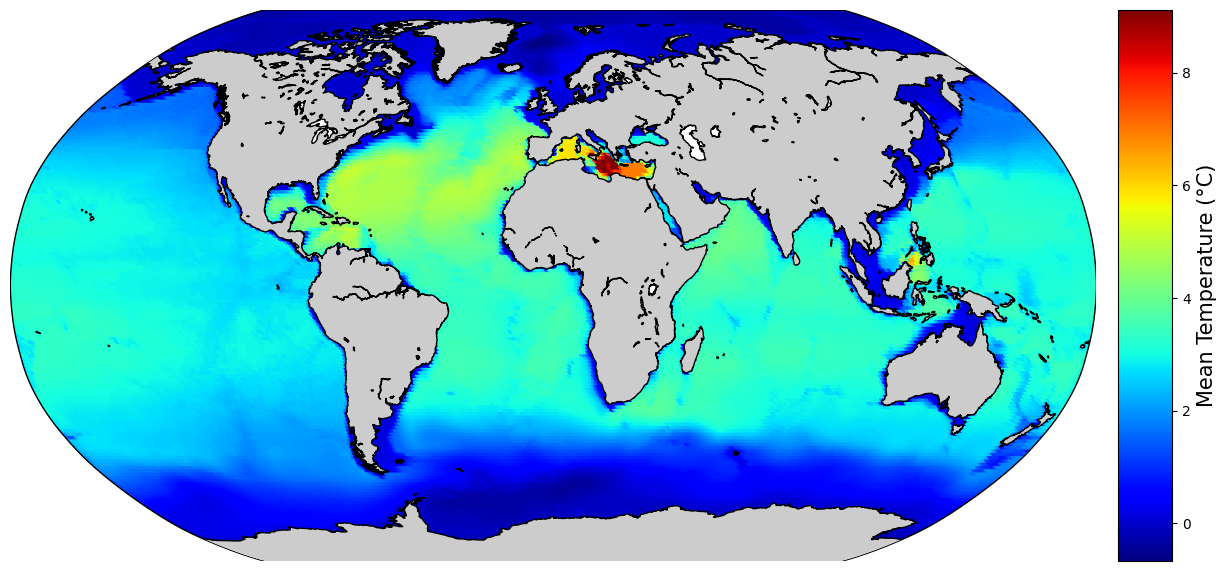

In [ ]:
plot_im(ravel(LON), ravel(LAT), ravel(mean_temp_map), 30, 'Mean Temperature (°C)')

Moving to SSH, just like how we did with the temperature, we calculate a weighted average and plot the corresponding time series. To properly interpret the results, we chose to work with SLA, sea Level Anomalies.

In [ ]:
# Mean of SSH
dS_ssh = R**2 * dϕ * dλ * np.cos(np.deg2rad(sla.latitude))
mean_ssh = (sla * dS_ssh).sum(dim=('latitude', 'longitude')) / (dS_ssh.sum(dim=('latitude')) * 1440)
mean_ssh.compute()

<xarray.DataArray (time: 312)>
array([-2.64322930e-03, -4.54559824e-03, -4.12062659e-03, -4.45959537e-03,
       -4.02187833e-03, -3.58554069e-03, -1.32318809e-03,  8.33269099e-04,
        2.82334121e-03,  4.70857387e-03,  3.87700517e-03,  2.45749833e-03,
        1.48254483e-03, -2.31816109e-03, -2.00937975e-03, -2.62799953e-03,
       -3.61682034e-03, -3.11589656e-03, -1.17317314e-03,  1.47885373e-03,
        2.76396644e-03,  6.34119226e-03,  5.22726102e-03,  3.34920048e-03,
        1.61256653e-03,  5.38965626e-04, -6.84468491e-04, -3.29180776e-03,
       -2.87788456e-03, -7.99009631e-04, -6.73483005e-04,  8.53002951e-04,
        4.76863791e-03,  6.65402596e-03,  7.49075666e-03,  6.57137238e-03,
        3.13059908e-03,  1.72475769e-03, -9.39164317e-05, -7.82040301e-04,
        8.22561268e-04,  1.72235716e-03,  4.65042438e-03,  4.39667697e-03,
        6.46227064e-03,  1.09420180e-02,  1.11217675e-02,  6.64164808e-03,
        4.26897005e-03,  1.45886046e-03,  9.93172261e-04,  5.13703442e-04,
        2.52992099e-03,  4.28199996e-03,  5.83339083e-03,  9.78993857e-03,
        1.34586227e-02,  1.59920493e-02,  1.37365881e-02,  1.05744432e-02,
        8.22296726e-03,  6.84044473e-03,  6.77103580e-03,  6.04838547e-03,
        6.32917296e-03,  6.08241400e-03,  7.51750605e-03,  9.45407869e-03,
        1.17613526e-02,  1.38489847e-02,  1.44666701e-02,  1.27528080e-02,
        9.94347413e-03,  6.72274779e-03,  6.48641029e-03,  6.86532491e-03,
        6.17506945e-03,  6.18422142e-03,  8.23704051e-03,  1.11506719e-02,
...
        3.40174475e-02,  3.64229027e-02,  3.86308904e-02,  4.12075876e-02,
        4.28648851e-02,  4.59437567e-02,  4.44412916e-02,  4.45119637e-02,
        4.22392023e-02,  3.97290055e-02,  3.85213558e-02,  3.64373965e-02,
        3.67800837e-02,  3.63101361e-02,  3.76901525e-02,  3.92076250e-02,
        4.11330027e-02,  4.35217338e-02,  4.38140784e-02,  4.30524186e-02,
        4.09265306e-02,  3.88361500e-02,  3.79342209e-02,  3.65591950e-02,
        3.67142984e-02,  3.80743126e-02,  4.04290589e-02,  4.24433865e-02,
        4.55717338e-02,  4.75666490e-02,  4.76463414e-02,  4.77660409e-02,
        4.56518937e-02,  4.46270300e-02,  4.37792333e-02,  4.31981369e-02,
        4.36523566e-02,  4.51806330e-02,  4.68832369e-02,  4.98465176e-02,
        5.31459645e-02,  5.69396304e-02,  5.58665876e-02,  5.44341788e-02,
        5.08449721e-02,  5.06476274e-02,  4.84272045e-02,  4.70282321e-02,
        4.77244321e-02,  4.87511014e-02,  4.92563028e-02,  5.08841329e-02,
        5.41556405e-02,  5.67169118e-02,  5.81552142e-02,  5.54147053e-02,
        5.25148681e-02,  5.02409865e-02,  4.92018510e-02,  4.92605501e-02,
        4.72205467e-02,  4.52543256e-02,  4.79294561e-02,  5.10572264e-02,
        5.44237748e-02,  5.66089925e-02,  5.63926759e-02,  5.52813783e-02,
        5.30794752e-02,  5.06067728e-02,  4.80009759e-02,  4.85368215e-02,
        4.83907537e-02,  4.89534837e-02,  5.05552839e-02,  5.31553352e-02,
        5.65864678e-02,  5.98786821e-02,  5.85943438e-02,  5.69838576e-02])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2018-12-01

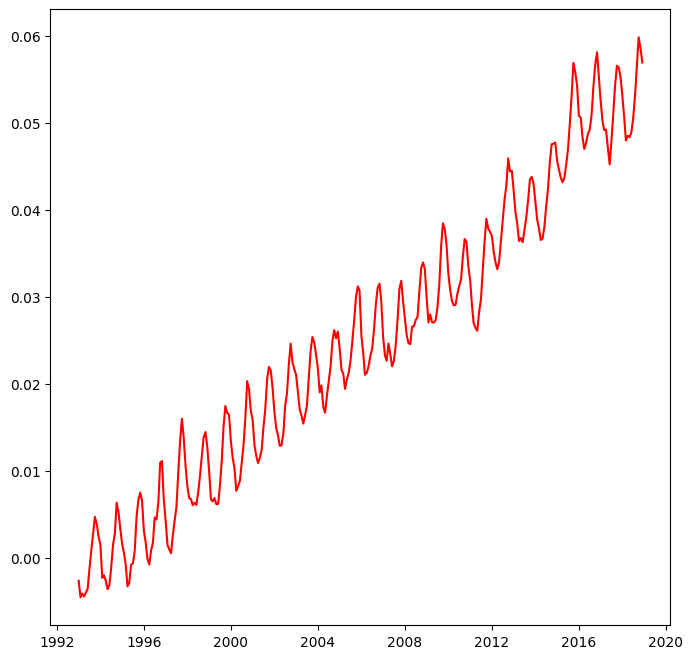

In [ ]:
time_ssh = ssh_ds['time']
figure(figsize=(8, 8))
plot(time_ssh, mean_ssh, color='red')

In [ ]:
# Define the window size for the running average
window_size = 24

# Calculate the running average using the rolling method and mean function
running_avg_ssh = mean_ssh.rolling(time=window_size, center=True).mean()

running_avg_ssh.compute()

<xarray.DataArray (time: 312)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.75765857e-04,  1.55896916e-06,  2.13415797e-04,  3.56589051e-04,
        4.05246868e-04,  4.52913275e-04,  5.69018736e-04,  5.96089781e-04,
        5.96912025e-04,  6.77966054e-04,  7.59026558e-04,  9.09599536e-04,
        1.08101096e-03,  1.14967988e-03,  1.31813483e-03,  1.39794580e-03,
        1.47486077e-03,  1.65983500e-03,  1.86142891e-03,  2.10407881e-03,
        2.22565477e-03,  2.37975078e-03,  2.57145186e-03,  2.81705629e-03,
        2.95424161e-03,  3.06492509e-03,  3.10325404e-03,  3.17315574e-03,
        3.33171870e-03,  3.55704394e-03,  3.76875267e-03,  4.03987241e-03,
        4.41224473e-03,  4.77432743e-03,  5.16341173e-03,  5.42365471e-03,
        5.59044933e-03,  5.80263133e-03,  6.01578496e-03,  6.30182464e-03,
        6.58642571e-03,  6.81586786e-03,  6.99753690e-03,  7.11699864e-03,
        7.32772371e-03,  7.54851879e-03,  7.66964240e-03,  7.80901334e-03,
        8.06364500e-03,  8.30008267e-03,  8.51941131e-03,  8.74829623e-03,
        9.01294712e-03,  9.16482831e-03,  9.24408754e-03,  9.34423961e-03,
        9.40093683e-03,  9.47245419e-03,  9.53361520e-03,  9.65515149e-03,
        9.90137713e-03,  1.01171177e-02,  1.03109778e-02,  1.04595130e-02,
        1.05282134e-02,  1.06074637e-02,  1.07234787e-02,  1.08627692e-02,
...
        3.71842126e-02,  3.76288288e-02,  3.79634912e-02,  3.82967989e-02,
        3.85511902e-02,  3.87462320e-02,  3.89348751e-02,  3.91821193e-02,
        3.94140496e-02,  3.95763540e-02,  3.97276511e-02,  3.98902063e-02,
        4.00305422e-02,  4.01429110e-02,  4.02117197e-02,  4.02866434e-02,
        4.03381350e-02,  4.04509204e-02,  4.05185409e-02,  4.06520847e-02,
        4.07876712e-02,  4.09298667e-02,  4.11339510e-02,  4.13530293e-02,
        4.16347268e-02,  4.19210715e-02,  4.22906755e-02,  4.26737207e-02,
        4.31170079e-02,  4.36175480e-02,  4.41766270e-02,  4.46788149e-02,
        4.51530549e-02,  4.55663233e-02,  4.60584682e-02,  4.64956758e-02,
        4.69318857e-02,  4.73906413e-02,  4.78355075e-02,  4.82033093e-02,
        4.85550071e-02,  4.89126699e-02,  4.92939308e-02,  4.97318005e-02,
        5.00504949e-02,  5.03364521e-02,  5.05703670e-02,  5.07963094e-02,
        5.10489099e-02,  5.11975845e-02,  5.12006550e-02,  5.12442475e-02,
        5.12946937e-02,  5.13479358e-02,  5.13341592e-02,  5.13560796e-02,
        5.13913796e-02,  5.14844838e-02,  5.14827816e-02,  5.14650220e-02,
        5.15278799e-02,  5.15556433e-02,  5.15640759e-02,  5.16182001e-02,
        5.17128336e-02,  5.18141180e-02,  5.19458585e-02,  5.19641555e-02,
        5.20295369e-02,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2018-12-01

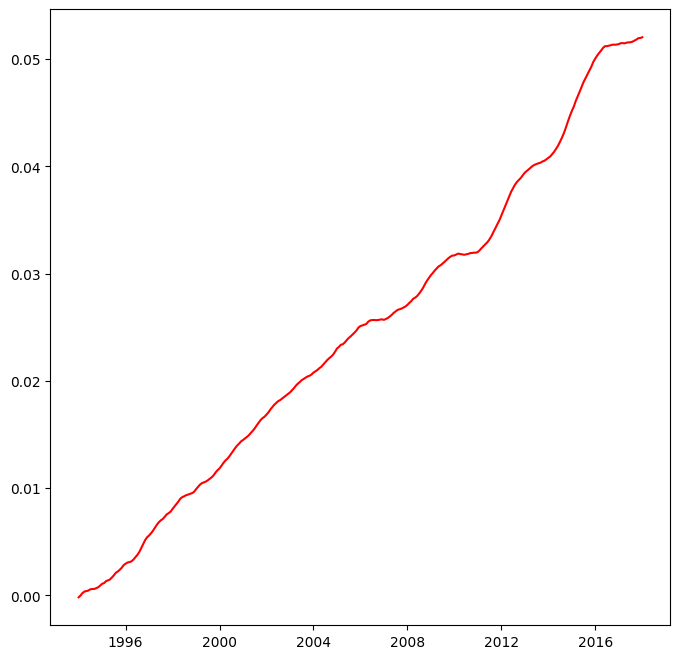

In [ ]:
figure(figsize=(8, 8))
plot(time_ssh, running_avg_ssh, color='red')

In [38]:
first_5_years_sla = sla.sel(time=slice('1993-01', '1998-01'))
last_5_years_sla = sla.sel(time=slice('2013-01', '2018-01'))

In [39]:
first_mean = first_5_years_sla.mean(dim='time', skipna=True)
last_mean = last_5_years_sla.mean(dim='time', skipna=True)

Before we plot the results, we have to convert them from m/20years (since we took the difference of the means with a 20-year gap) to mm/year. Finally, we have to substract the global mean from our data to center the plot around 0

In [40]:
tendency_ssh = last_mean - first_mean
tendency_ssh = tendency_ssh*1000/20
global_mean = tendency_ssh.mean(dim=["longitude", "latitude"], skipna=True)
global_mean.compute()
tendency_ssh -= global_mean
tendency_ssh.compute()

<xarray.DataArray 'sla' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9

In [41]:
longitude = ssh_ds['longitude']
latitude = ssh_ds['latitude']
LON_ssh, LAT_ssh = meshgrid(longitude, latitude)

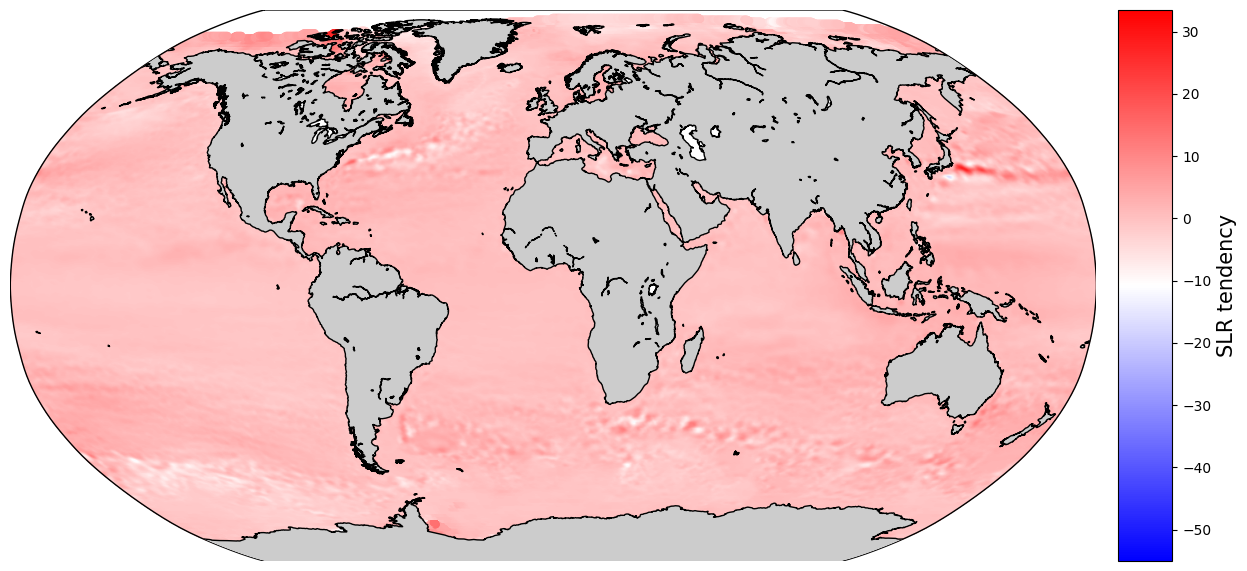

In [42]:
plot_im(ravel(LON_ssh), ravel(LAT_ssh), ravel(tendency_ssh), 30, 'SLR tendency', colormap='bwr', vmin=tendency_ssh.min().values, vmax=tendency_ssh.max().values)